Visualize peak embeddings

peaks of the same formula same substructure should be clustered closer togther

In [4]:
data = pd.read_csv("/r/hassounlab/spectra_data/msgym/MassSpecGym.tsv", sep="\t")

In [5]:
data.head()

identifier                                                mzs  \
0  MassSpecGymID0000001  91.0542,125.0233,154.0499,155.0577,185.0961,20...   
1  MassSpecGymID0000002  91.0542,125.0233,155.0577,185.0961,229.0859,24...   
2  MassSpecGymID0000003  69.0343,91.0542,125.0233,127.039,153.0699,154....   
3  MassSpecGymID0000004  69.0343,91.0542,110.06,111.0441,112.0393,120.0...   
4  MassSpecGymID0000005  91.0542,125.0233,185.0961,229.0859,246.1125,28...   

                                         intensities  \
0  0.24524524524524524,1.0,0.08008008008008008,0....   
1  0.0990990990990991,0.28128128128128127,0.04004...   
2  0.03403403403403404,0.31431431431431434,1.0,0....   
3  0.17917917917917917,0.47347347347347346,0.0380...   
4  0.07807807807807808,0.1841841841841842,0.03503...   

                                          smiles        inchikey    formula  \
0  CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC  VFMQMACUYWGDOJ  C16H17NO4   
1  CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC  VFMQMACUYWGDOJ  C16H17NO4   
2  CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC  VFMQMACUYWGDOJ  C16H17NO4   
3  CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC  VFMQMACUYWGDOJ  C16H17NO4   
4  CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC  VFMQMACUYWGDOJ  C16H17NO4   

  precursor_formula  parent_mass  precursor_mz  adduct instrument_type  \
0         C16H18NO4   287.115224      288.1225  [M+H]+        Orbitrap   
1         C16H18NO4   287.115224      288.1225  [M+H]+        Orbitrap   
2         C16H18NO4   287.115224      288.1225  [M+H]+        Orbitrap   
3         C16H18NO4   287.115224      288.1225  [M+H]+        Orbitrap   
4         C16H18NO4   287.115224      288.1225  [M+H]+        Orbitrap   

   collision_energy   fold  simulation_challenge  
0              30.0  train                  True  
1              20.0  train                  True  
2              40.0  train                  True  
3              55.0  train                  True  
4              10.0  train                  True

In [ ]:
fomula_to_smiles = defaultdict(list)


for i, row in data.iterrows():
    formula = row['formula']
    smiles = row['smiles']
    if smiles in fomula_to_smiles[formula]:
        continue

    fomula_to_smiles[formula].append(smiles)

Max number of unique smiles for a formula: 39, formulas: ['C27H30O15']


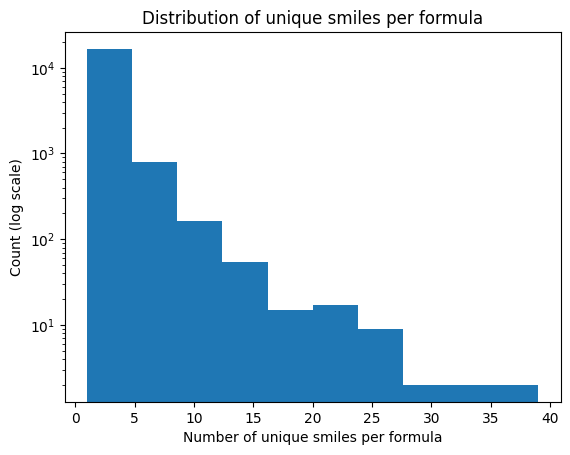

In [ ]:
n_smiles = [len(smiles) for smiles in fomula_to_smiles.values()]
max_n_smiles = max(n_smiles)
formula_with_max_smiles = [formula for formula, smiles in fomula_to_smiles.items() if len(smiles) == max_n_smiles]
print(f"Max number of unique smiles for a formula: {max_n_smiles}, formulas: {formula_with_max_smiles}")
plt.hist(n_smiles)
plt.yscale('log')
plt.xlabel("Number of unique smiles per formula")
plt.ylabel("Count (log scale)")
plt.title("Distribution of unique smiles per formula")
plt.show()

Selected formula: C18H19NO4, number of unique smiles: 22


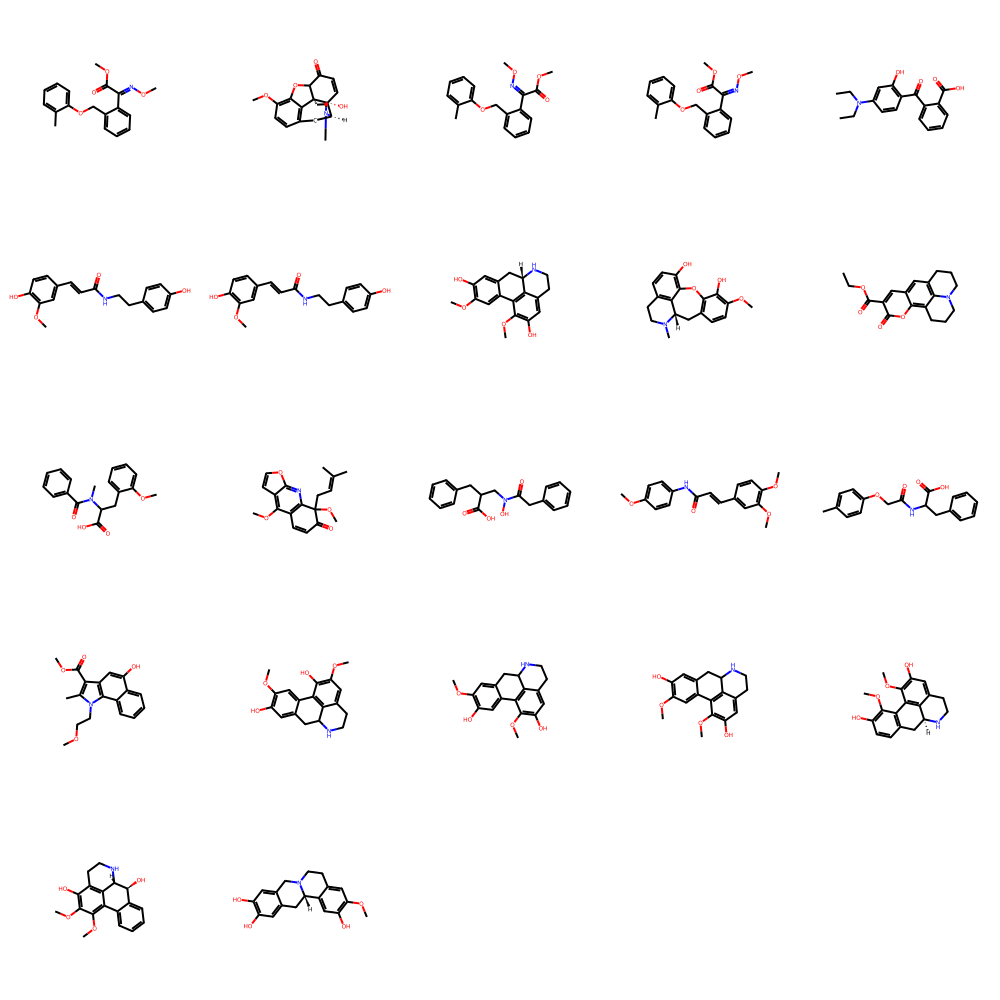

In [47]:
# look at smiles with a formula with at least k unique smiles
# k = 20
# formula_to_count = {formula: len(smiles) for formula, smiles in fomula_to_smiles.items()}
# formula_with_k_smiles = [formula for formula, count in formula_to_count.items() if count >= k]

# # randomly select a formula
# formula = np.random.choice(formula_with_k_smiles)
# print(f"Selected formula: {formula}, number of unique smiles: {formula_to_count[formula]}")

# good formulas so far
# good_formulas = ['C20H22N2O2', 'C18H19NO4','C16H14O5', 'C15H12O5', 'C16H12O5']

data = dataset.metadata

formula = 'C18H19NO4'

# visualize all smiles with the formula
smiles = data[data['formula'] == formula]['smiles'].unique().tolist()

print(f"Selected formula: {formula}, number of unique smiles: {len(smiles)}")
mols = [Chem.MolFromSmiles(s) for s in smiles]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
img

Model

In [1]:
import sys
sys.path.insert(0, "/data/yzhouc01/MassSpecGym")
sys.path.insert(0, "/data/yzhouc01/FILIP-MS")

from rdkit import RDLogger
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from massspecgym.models.base import Stage
import os

from mvp.utils.data import get_spec_featurizer, get_mol_featurizer, get_ms_dataset
from mvp.utils.models import get_model

from mvp.definitions import TEST_RESULTS_DIR
import yaml
from functools import partial
# Suppress RDKit warnings and errors
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Load model and data

param_pth = '/data/yzhouc01/FILIP-MS/experiments/20250913_optimized_filip-model/lightning_logs/version_0/hparams.yaml'
with open(param_pth) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

spec_featurizer = get_spec_featurizer(params['spectra_view'], params)
mol_featurizer = get_mol_featurizer(params['molecule_view'], params)
dataset = get_ms_dataset(params['spectra_view'], params['molecule_view'], spec_featurizer, mol_featurizer, params)

Data path:  /r/hassounlab/spectra_data/msgym/MassSpecGym.tsv
Processing formula spectra


100%|██████████| 213548/213548 [00:15<00:00, 13819.35it/s]
/data/yzhouc01/FILIP-MS/mvp/data/datasets.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['spec'] = tmp_df.apply(lambda row: data_utils.make_tmp_subformula_spectra(row), axis=1)


In [2]:
# load model
import torch 
checkpoint_pth = "/data/yzhouc01/FILIP-MS/experiments/20250913_optimized_filip-model/epoch=1993-train_loss=0.10.ckpt"
params['checkpoint_pth'] = checkpoint_pth
model = get_model(params['model'], params)

Loaded Model from checkpoint


In [48]:
formula = 'C18H19NO4'

idx_of_interet = dataset.metadata[dataset.metadata['formula'] == formula].index.tolist()


In [49]:
# identify subformula frequency
subformula_to_spectra_idx = defaultdict(list)
subformula_to_smiles = defaultdict(set)

for idx in idx_of_interet:
    formula = dataset.metadata.loc[idx, 'formula']
    smiles = dataset.metadata.loc[idx, 'smiles']

    spectra = dataset.spectra[idx]
    for f in spectra.metadata['formulas']:
        subformula_to_spectra_idx[f].append(idx)
        subformula_to_smiles[f].add(smiles)

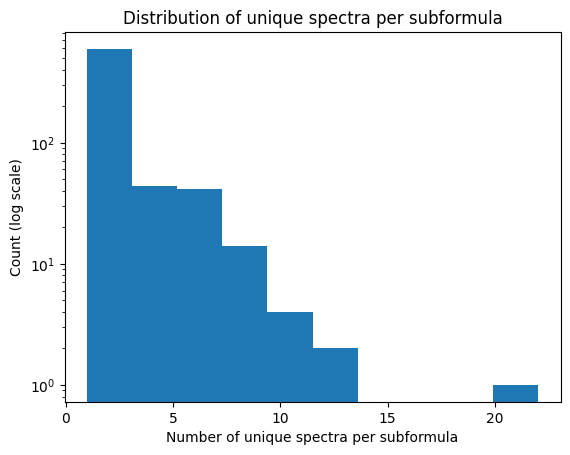

In [50]:
subformula_to_unique_smiles = {f: len(smiles) for f, smiles in subformula_to_smiles.items()}
plt.hist(subformula_to_unique_smiles.values())
plt.yscale('log')
plt.xlabel("Number of unique spectra per subformula")
plt.ylabel("Count (log scale)")
plt.title("Distribution of unique spectra per subformula")
plt.show()

In [53]:
# print subformula with at least 50 unique smiles
for f, ct in subformula_to_unique_smiles.items():
    if ct >= 10:
        print(f, ct)

C9H6 12
C13H8 11
C14H8 10
C14H9 10
C14H10O 10
C18H19NO4 22
C7H6 12


In [54]:
# collect peak embeddings corresponding to seelected subformula
subformula = 'C14H10O'
peak_embeddings = []
seleced_smiles = []

# Embeddings
model = model.to(torch.device('cpu'))
model.eval()
for i in subformula_to_spectra_idx[subformula]:
    with torch.no_grad():
        p_idx = np.where(dataset.spectra[i].metadata['formulas'] == formula)
        smiles = dataset.metadata.loc[i, 'smiles']
        seleced_smiles.append(smiles)
        spec_enc, _ = model.forward(dataset[i], stage='test')
        peak_embeddings.append(spec_enc[p_idx][0].cpu().numpy())

In [10]:
import umap

(28, 512)


/data/yzc-conda/spec/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



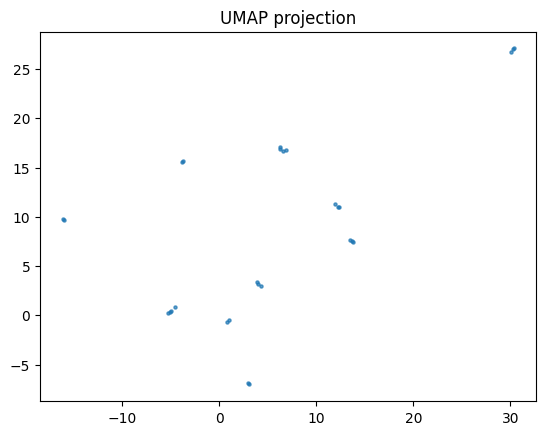

In [56]:
embeddings = np.array(peak_embeddings)
print(embeddings.shape)

# Initialize UMAP
reducer = umap.UMAP(n_neighbors=2, n_components=2, random_state=42)

# Fit and transform embeddings
embedding_2d = reducer.fit_transform(embeddings)

# Plot the 2D projection
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=5, alpha=0.7)
plt.title("UMAP projection")
plt.show()

In [57]:
import hdbscan
import pandas as pd
import numpy as np

# embedding_2d is your UMAP output
clusterer = hdbscan.HDBSCAN()
labels = clusterer.fit_predict(embedding_2d)  # -1 = noise

# Combine with SMILES
df = pd.DataFrame({
    "SMILES": seleced_smiles,
    "Cluster": labels
})

/data/yzc-conda/spec/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/data/yzc-conda/spec/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [59]:
df.Cluster.value_counts()

Cluster
 1    11
 0    10
-1     7
Name: count, dtype: int64

0 6
Cluster 0


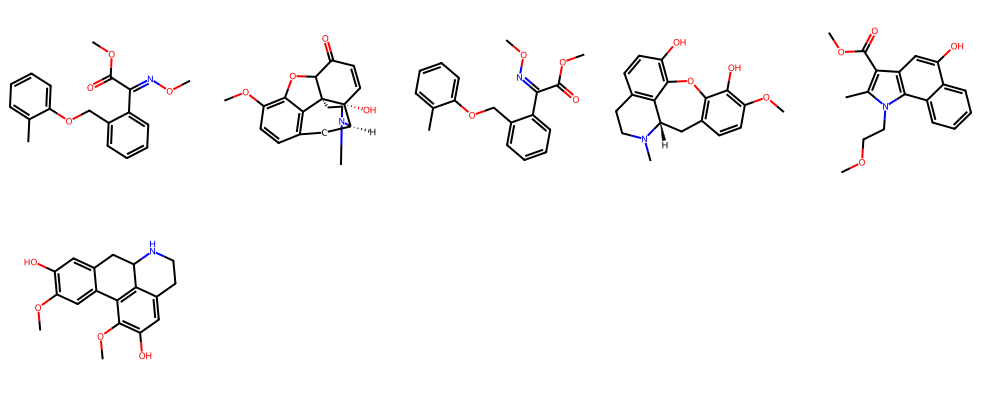

1 3
Cluster 1


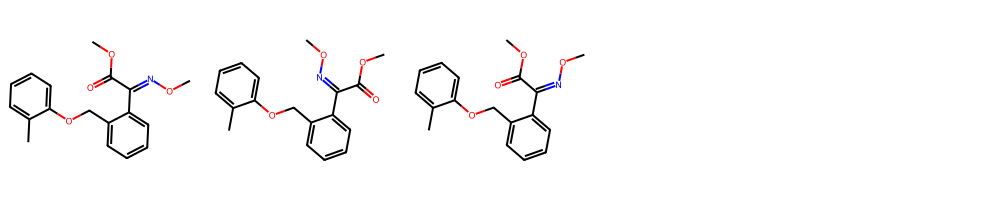

In [60]:
for i in df['Cluster'].unique():
    if i == -1:
        continue
    print(i, len(df[df['Cluster']==i]['SMILES'].unique().tolist()))
    print(f'Cluster {i}')
    mols = [Chem.MolFromSmiles(s) for s in df[df['Cluster']==i]['SMILES'].unique().tolist()]
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
    display(img)



# strategy 2

In [63]:
subformula_to_smiles = defaultdict(set)
subformula_to_spectra_idx = defaultdict(list)

# iterate through all spectra
for i, d in dataset.metadata.iterrows():
    smiles = d['smiles']
    spec = dataset.spectra[i]
    for f in spec.metadata['formulas']:
        subformula_to_smiles[f].add(smiles)
        subformula_to_spectra_idx[f].append(i)

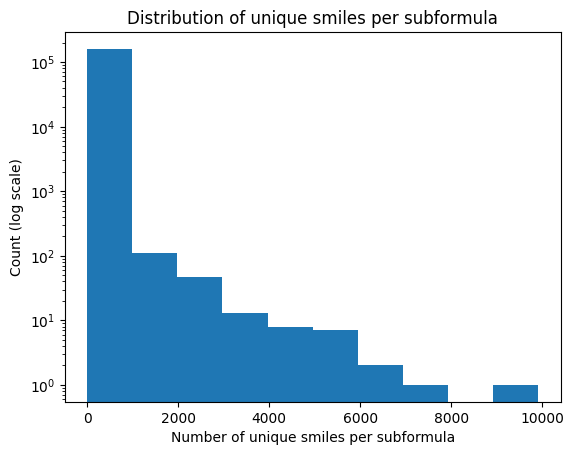

In [64]:
plt.hist([len(s) for s in subformula_to_smiles.values()])
plt.yscale('log')
plt.xlabel("Number of unique smiles per subformula")
plt.ylabel("Count (log scale)")
plt.title("Distribution of unique smiles per subformula")
plt.show()

In [70]:
# choose a subformula with at least 50 unique smiles but not too generic

subformula_data = []
for f in subformula_to_smiles.keys():
    subformula_data.append([f, list(subformula_to_smiles[f]), subformula_to_spectra_idx[f]])

subformula_df = pd.DataFrame(subformula_data, columns=['Subformula', 'Unique_SMILES', 'Spectra_Indices'])

In [78]:
# add additional info
subformula_df['n_smiles'] = subformula_df['Unique_SMILES'].apply(len)
subformula_df['has_nitrogen'] = subformula_df['Subformula'].apply(lambda x: 'N' in x)
subformula_df['has_oxygen'] = subformula_df['Subformula'].apply(lambda x: 'O' in x)

In [79]:
subformula_df[(subformula_df['n_smiles'] >= 100) & (subformula_df['has_oxygen']) & (subformula_df['has_nitrogen'])].sort_values(by='n_smiles', ascending=False)

Subformula                                      Unique_SMILES  \
1046       C9H7NO  [COC1=CC(=CC(=C1)NC(=O)CN2C3=CC=CC=C3C(=CC2=O)...   
1052      C10H9NO  [C1OC2=CC3=CC(=C(N=C3C=C2O1)N)C(=O)NC4=CC=CC=C...   
2587       C8H7NO  [C1CCOC(C1)CN2C=C(C=N2)NC(=O)C3=CC4=C(C=C3)NC=...   
1159       C5H5NO  [C1OC2=CC3=CC(=C(N=C3C=C2O1)N)C(=O)NC4=CC=CC=C...   
2787       C4H5NO  [C1=CC=C(C=C1)C[C@@H](C(=O)N[C@@H](CCC(=O)N)C(...   
...           ...                                                ...   
2174    C10H18N2O  [CC(C)[C@H](C(=O)NCC1=CC=C(C=C1)OC)NC(=O)C2CCN...   
6157      C6H8NO2  [CC1=CC(=O)OC2=C1C=CC(=C2)NC(=O)[C@@H]3CCCN3C(...   
4045     C3H7N2O2  [CC(C)CS(=O)(=O)NCC(C1=COC=C1)N2CCSCC2, CCC1CN...   
11009  C15H10N2O2  [CC(C)N1C=C(C=N1)NC(=O)CC2=CC=C(C=C2)OC3=NC=NC...   
10951     C9H5N2O  [CCOC(=O)C1=CN=C2C=CC(=NC2=C1Br)OC, CC(C)C1=C2...   

                                         Spectra_Indices  n_smiles  \
1046   [392, 396, 671, 674, 675, 677, 901, 905, 910, ...      2345   
1052   [392, 393, 394, 396, 397, 398, 901, 902, 904, ...      1788   
2587   [1696, 1698, 1699, 1704, 1705, 1706, 1707, 170...      1706   
1159   [421, 422, 424, 425, 1047, 1721, 1725, 1727, 1...      1450   
2787   [1779, 1780, 1787, 1789, 1790, 1791, 1793, 179...      1380   
...                                                  ...       ...   
2174   [1171, 1179, 51943, 51954, 62242, 82752, 82754...       100   
6157   [4680, 6057, 7397, 8570, 9357, 21802, 23017, 2...       100   
4045   [2989, 7004, 9280, 9295, 9298, 20159, 35354, 3...       100   
11009  [10980, 10981, 10982, 10987, 36081, 36087, 360...       100   
10951  [10908, 10914, 10915, 10956, 10957, 10958, 115...       100   

       has_nitrogen  has_oxygen  
1046           True        True  
1052           True        True  
2587           True        True  
1159           True        True  
2787           True        True  
...             ...         ...  
2174           True        True  
6157           True        True  
4045           True        True  
11009          True        True  
10951          True        True  

[547 rows x 6 columns]

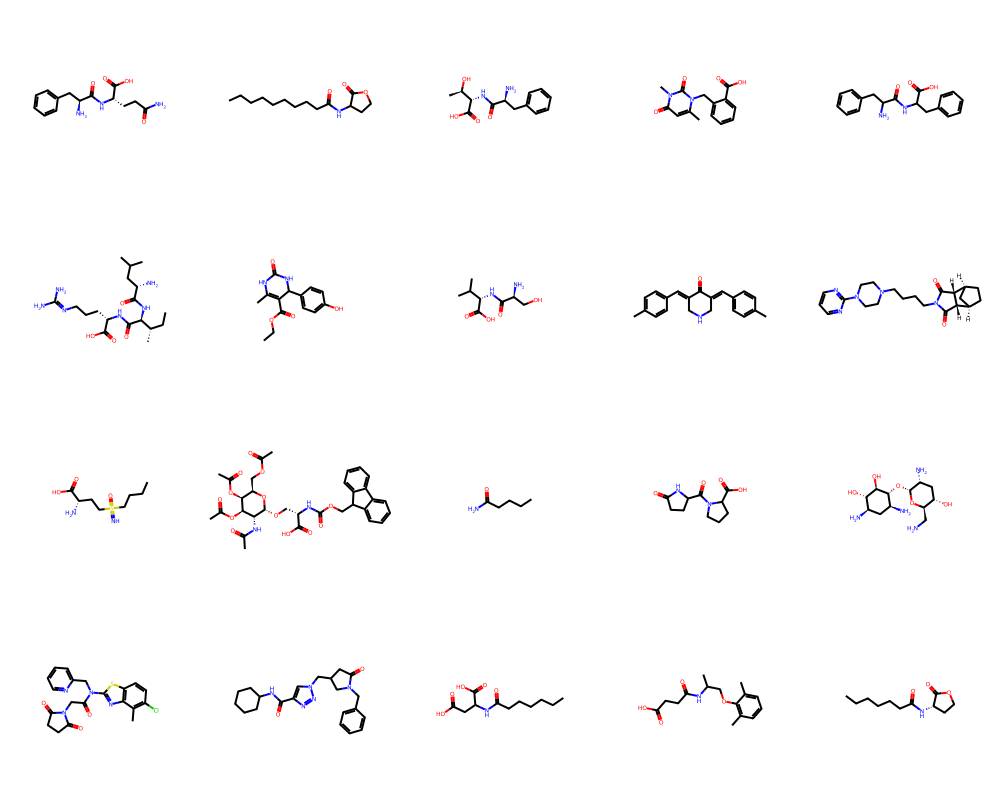

In [82]:
subformula = 'C4H5NO'
spectra_indices = subformula_df[subformula_df['Subformula'] == subformula]['Spectra_Indices'].values[0]
sampled_smiles = subformula_df[subformula_df['Subformula'] == subformula]['Unique_SMILES'].values[0][:20]
mols = [Chem.MolFromSmiles(s) for s in sampled_smiles]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
img

In [86]:
# select one spectra indx per smile

all_smiles = subformula_df[subformula_df['Subformula'] == subformula]['Unique_SMILES'].values[0]
selected_indecies = [] 
for s in all_smiles:
    idx = dataset.metadata[(dataset.metadata['smiles'] == s) & (dataset.metadata.index.isin(spectra_indices))].index[0]
    selected_indecies.append(idx)


In [100]:
# collect peak embeddings corresponding to seelected subformula
peak_embeddings = []
seleced_smiles = []

# Embeddings
model = model.to(torch.device('cpu'))
model.eval()
for i in selected_indecies:
    with torch.no_grad():
        p_idx = np.where(dataset.spectra[i].metadata['formulas'] == subformula)
        smiles = dataset.metadata.loc[i, 'smiles']
        seleced_smiles.append(smiles)
        spec_enc, _ = model.forward(dataset[i], stage='test')
        peak_embeddings.append(spec_enc[p_idx][0].cpu().numpy())

(1380, 512)


/data/yzc-conda/spec/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



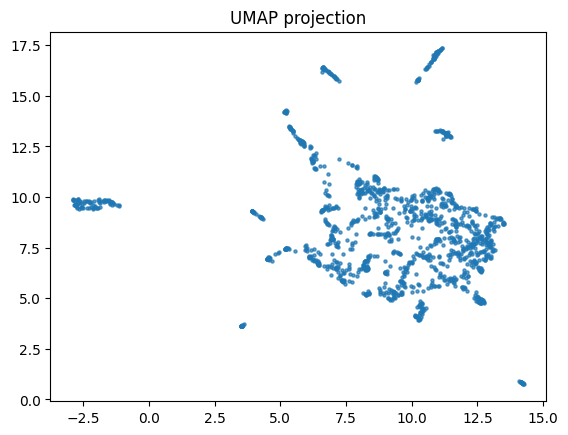

In [111]:
embeddings = np.array(peak_embeddings)
print(embeddings.shape)

# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)

# Fit and transform embeddings
embedding_2d = reducer.fit_transform(embeddings)

# Plot the 2D projection
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=5, alpha=0.7)
plt.title("UMAP projection")
plt.show()

In [115]:
import hdbscan
import pandas as pd
import numpy as np

# embedding_2d is your UMAP output
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
labels = clusterer.fit_predict(embedding_2d)  # -1 = noise

# Combine with SMILES
df = pd.DataFrame({
    "SMILES": seleced_smiles,
    "Cluster": labels
})

/data/yzc-conda/spec/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/data/yzc-conda/spec/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



5 37
Cluster 5


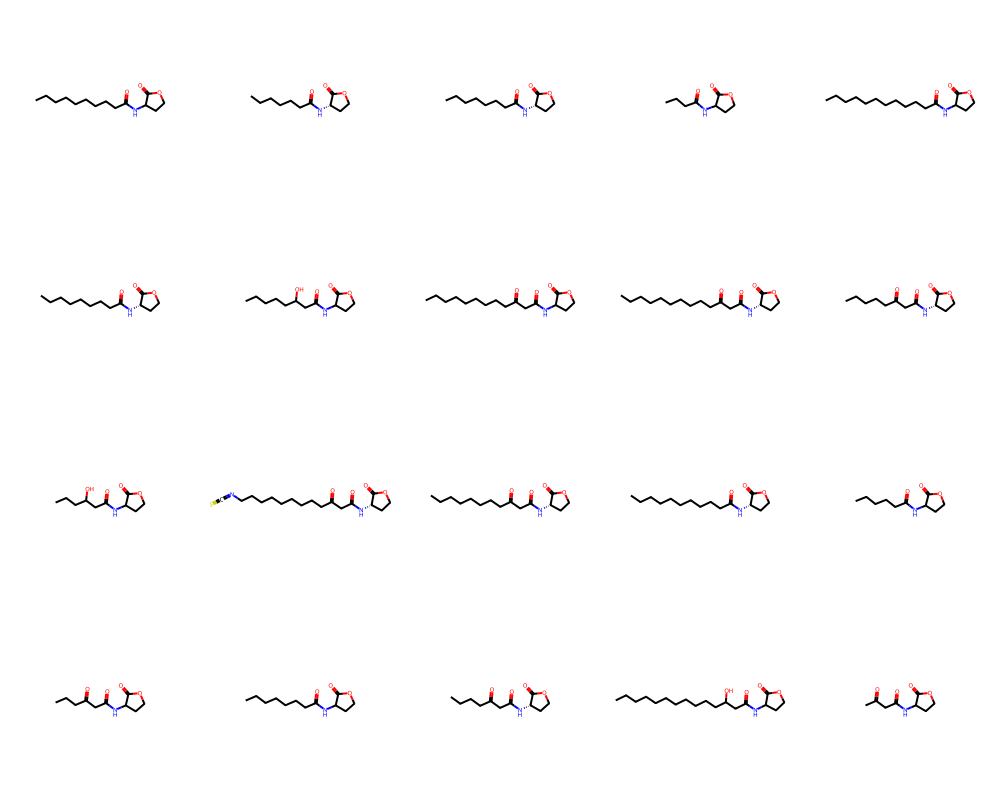

12 36
Cluster 12


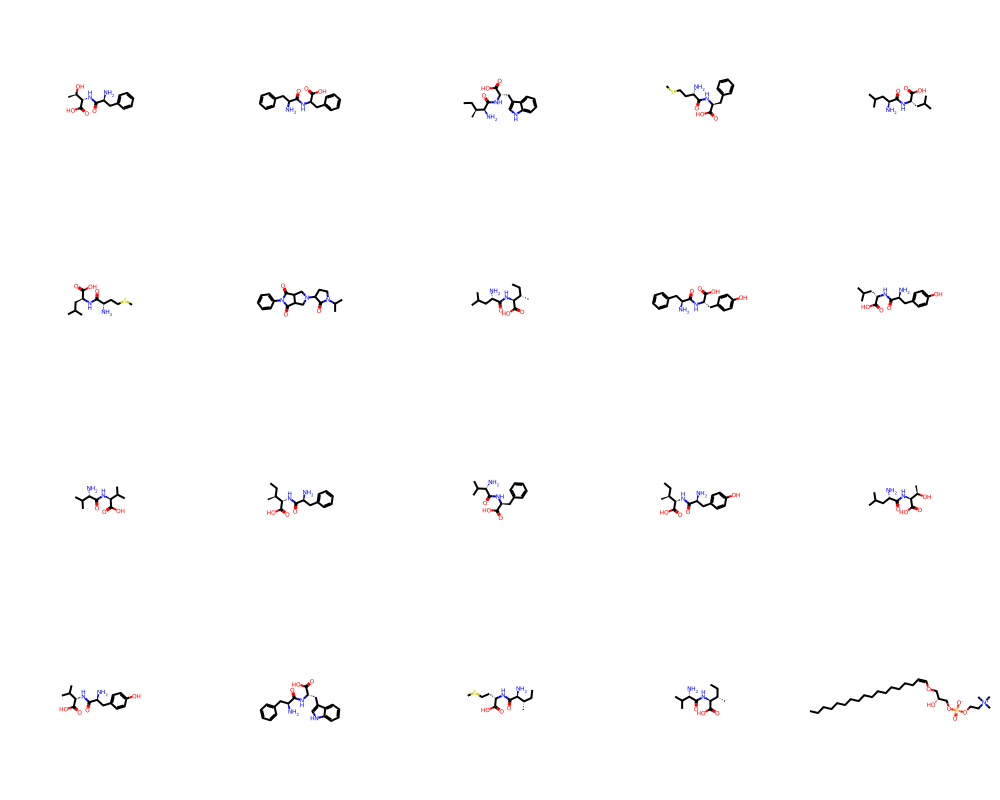

40 31
Cluster 40


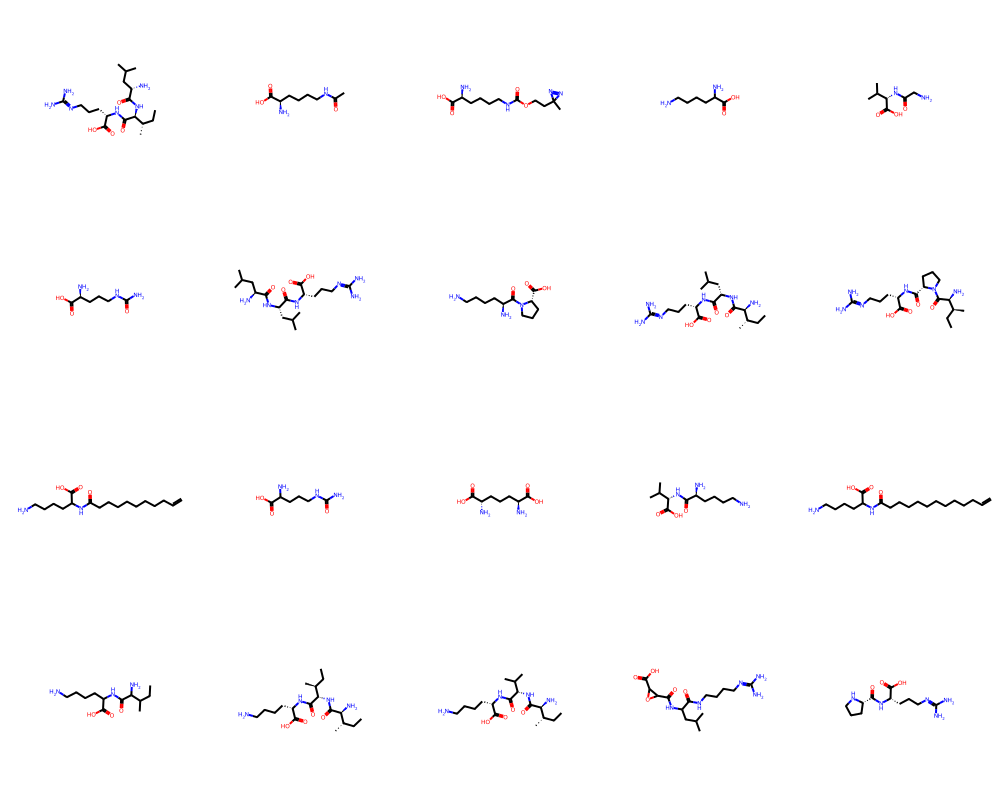

34 29
Cluster 34


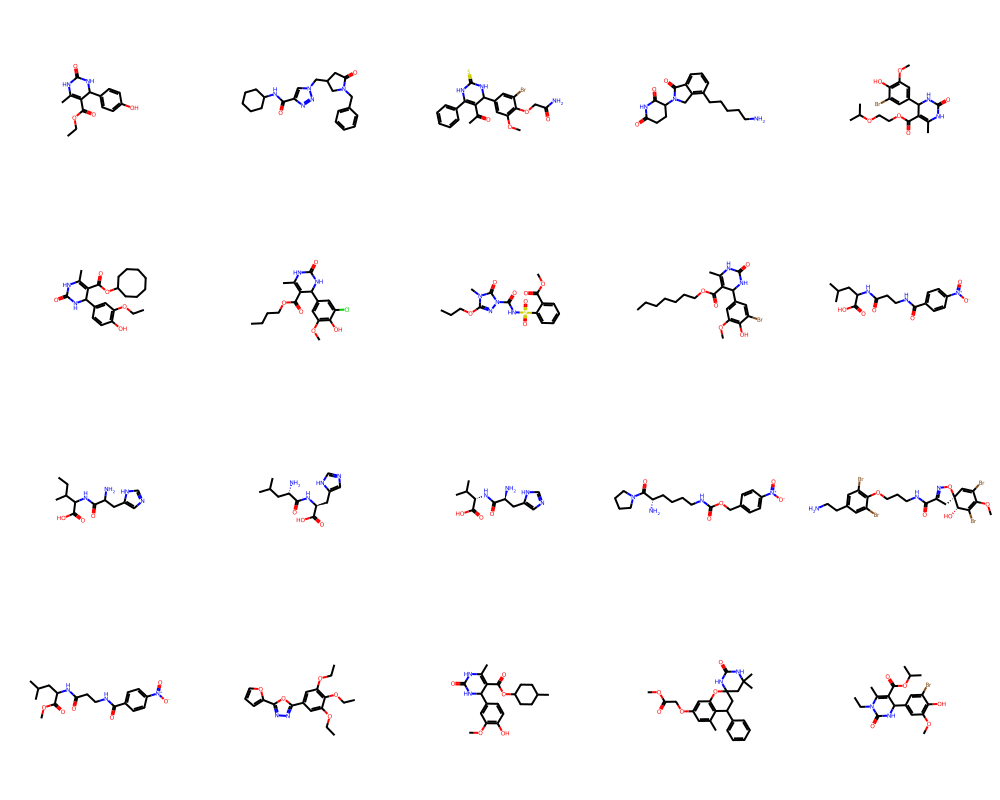

25 8
Cluster 25


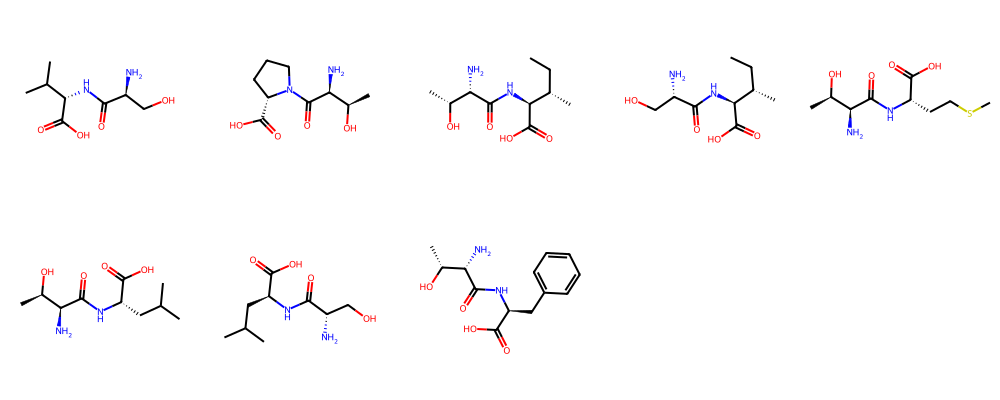

23 20
Cluster 23


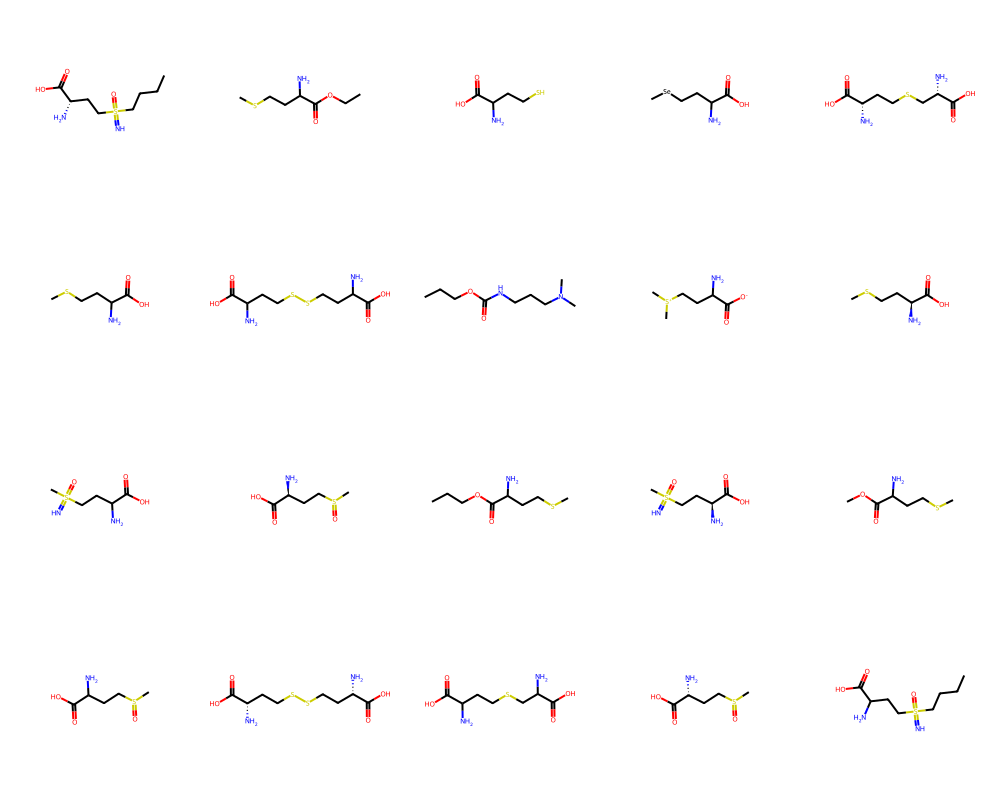

22 38
Cluster 22


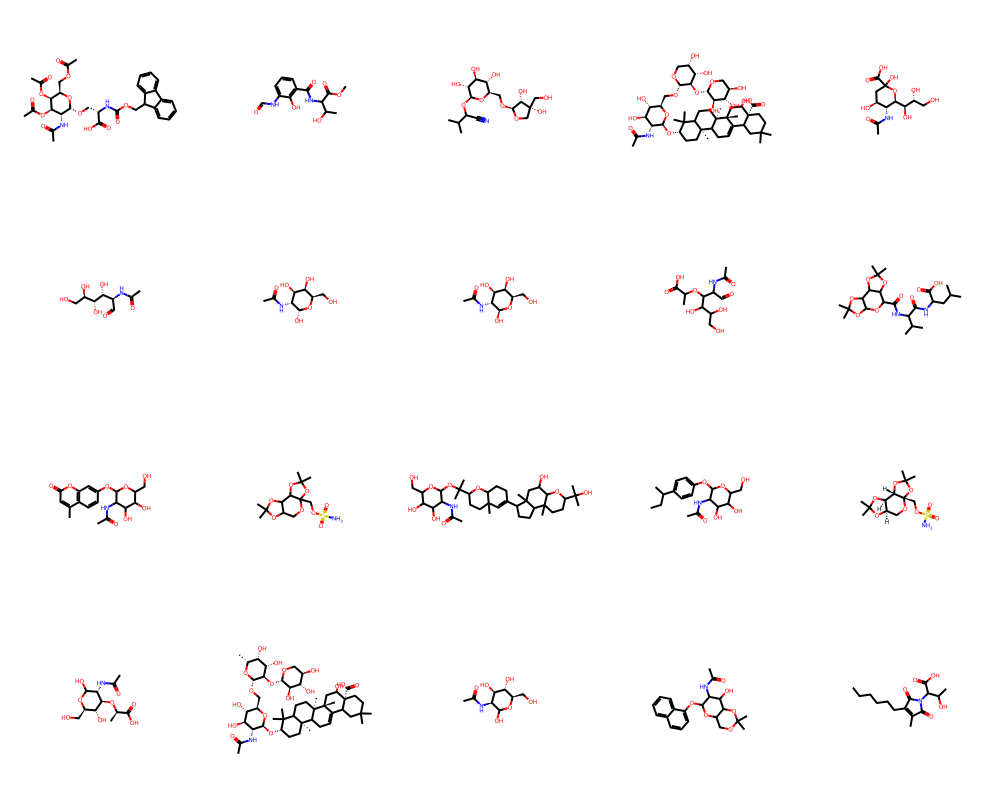

43 13
Cluster 43


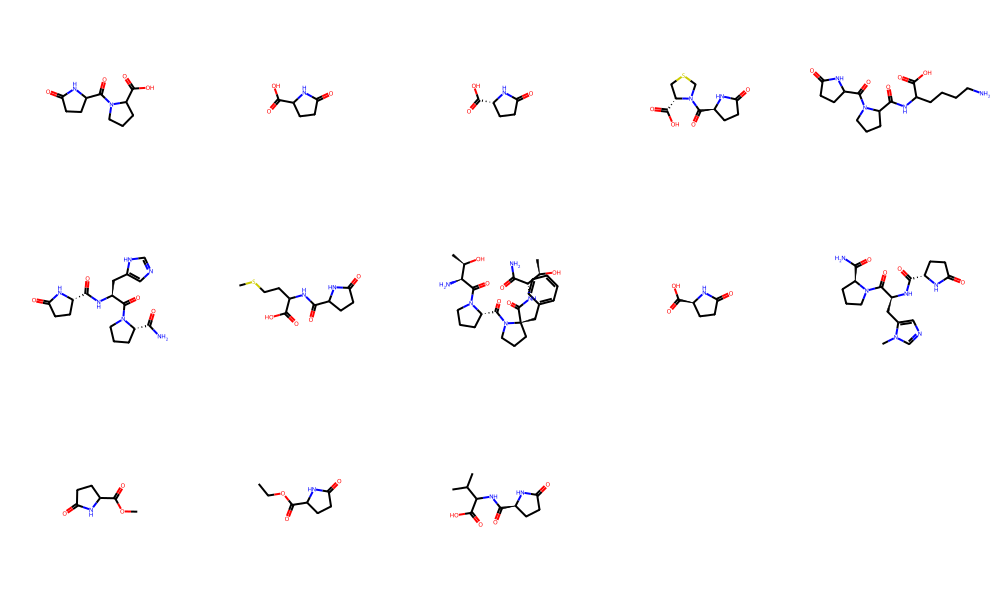

18 16
Cluster 18


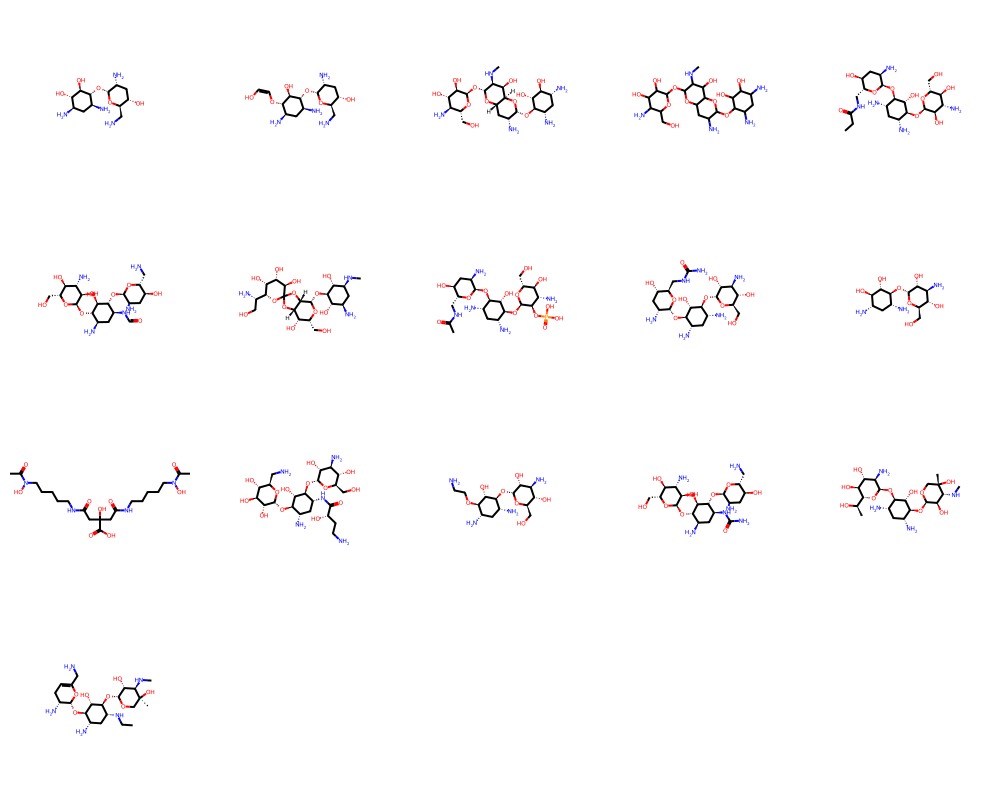

In [118]:
for i in df['Cluster'].unique().tolist()[0:10]:
    if i == -1:
        continue
    print(i, len(df[df['Cluster']==i]['SMILES'].unique().tolist()))
    print(f'Cluster {i}')
    mols = [Chem.MolFromSmiles(s) for s in df[df['Cluster']==i]['SMILES'].unique().tolist()[:20]]
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
    display(img)